
<img src="images/green-divider.png" style="width: 100%;" />


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Stack Overflow Annual Developer Survey - 2023

In [3]:
df = pd.read_csv("stack-overflow-developer-survey-2023/survey_results_public.csv")


In [4]:
display(df.columns)
display(df.head())
display(df.dtypes.value_counts())

Index(['ResponseId', 'Q120', 'MainBranch', 'Age', 'Employment', 'RemoteWork',
       'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline',
       'LearnCodeCoursesCert', 'YearsCode', 'YearsCodePro', 'DevType',
       'OrgSize', 'PurchaseInfluence', 'TechList', 'BuyNewTool', 'Country',
       'Currency', 'CompTotal', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith',
       'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith',
       'PlatformWantToWorkWith', 'WebframeHaveWorkedWith',
       'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith',
       'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith',
       'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith',
       'NEWCollabToolsWantToWorkWith', 'OpSysPersonal use',
       'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith',
       'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncHaveWorkedWith',
       'OfficeStackSyncWantToWorkWith', 'AISearchHaveWorkedWith',
       'AISearchWan

,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,...,6-10 times a week,6-10 times a week,3-5 times a week,30-60 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,250000.0
3,4,I agree,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Friend or family member;Other online...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,1-2 times a week,15-30 minutes a day,30-60 minutes a day,Automated testing;Continuous integration (CI) ...,NaN,Appropriate in length,Easy,156000.0
4,5,I agree,I am a developer by profession,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,Hobby;Contribute to open-source projects;Profe...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,...,1-2 times a week,1-2 times a week,3-5 times a week,60-120 minutes a day,30-60 minutes a day,Microservices;Automated testing;Observability ...,Other,Appropriate in length,Neither easy nor difficult,23456.0


object     80
float64     3
int64       1
Name: count, dtype: int64

### Schema

How do the questions from the survey translate to column names?

In [5]:
from IPython.display import HTML, display
import pandas as pd

# Load the schema file
schema = pd.read_csv("stack-overflow-developer-survey-2023/survey_results_schema.csv")

# To prevent truncation of columns, change the default options
pd.set_option('display.max_colwidth', None)

# To prevent truncation of cells, change the default options 
pd.set_option('display.max_rows', None)

# Function to display HTML content correctly
def display_html_content(html):
    display(HTML(html))

# Apply the display_html_content function to each row in the DataFrame
for index, row in schema[4:].iterrows():
    qname = row['qname']
    question = row['question']
    print(f"QNAME: {qname}")
    display_html_content(question)


QNAME: S1


QNAME: MainBranch


QNAME: Age


QNAME: Employment


QNAME: RemoteWork


QNAME: CodingActivities


QNAME: S2


QNAME: EdLevel


QNAME: LearnCode


QNAME: LearnCodeOnline


QNAME: LearnCodeCoursesCert


QNAME: YearsCode


QNAME: YearsCodePro


QNAME: DevType


QNAME: OrgSize


QNAME: PurchaseInfluence


QNAME: TechList


QNAME: BuyNewTool


QNAME: Country


QNAME: Currency


QNAME: CompTotal


QNAME: S3


QNAME: Language


QNAME: Database


QNAME: Platform


QNAME: Webframe


QNAME: MiscTech


QNAME: ToolsTech


QNAME: NEWCollabTools


QNAME: OpSys


QNAME: OfficeStackAsync


QNAME: OfficeStackSync


QNAME: AISearch


QNAME: AIDev


QNAME: S4


QNAME: NEWSOSites


QNAME: SOVisitFreq


QNAME: SOAccount


QNAME: SOPartFreq


QNAME: SOComm


QNAME: S5


QNAME: SOAI


QNAME: AISelect


QNAME: AISent


QNAME: AIAcc


QNAME: AIBen


QNAME: AITool


QNAME: AINext


QNAME: AIOpen


QNAME: S6


QNAME: TBranch


QNAME: ICorPM


QNAME: WorkExp


QNAME: Knowledge


QNAME: Frequency


QNAME: TimeSearching


QNAME: TimeAnswering


QNAME: ProfessionalTech


QNAME: Industry


QNAME: SOTeamsUsage


QNAME: S7


QNAME: SurveyLength


QNAME: SurveyEase


QNAME: Knowledge_1


QNAME: Knowledge_2


QNAME: Knowledge_3


QNAME: Knowledge_4


QNAME: Knowledge_5


QNAME: Knowledge_6


QNAME: Knowledge_7


QNAME: Knowledge_8


QNAME: Frequency_1


QNAME: Frequency_2


QNAME: Frequency_3


In [6]:
# Load the schema file
schema = pd.read_csv("stack-overflow-developer-survey-2023/survey_results_schema.csv")

# To prevent truncation of columns, change the default options
pd.set_option('display.max_colwidth', None)

# To prevent truncation of cells, change the default options 
pd.set_option('display.max_rows', None)

schema[["qname", "question"]][4:]

,qname,question
4,S1,"<span style=""font-size:22px; font-family: arial,helvetica,sans-serif; font-weight: 700;"">Basic Information</span><br>\n<br>\n<p><span style=""font-size:16px; font-family:arial,helvetica,sans-serif;"">The first section will focus on some basic information about who you are.<br>\n<br>\nMost questions in this section are required. Required questions are noted with *.</span></p>"
5,MainBranch,"Which of the following options best describes you today? For the purpose of this survey, a developer is ""someone who writes code"". *"
6,Age,What is your age? *
7,Employment,Which of the following best describes your current employment status? Select all that apply.
8,RemoteWork,Which best describes your current work situation?
9,CodingActivities,Which of the following best describes the code you write outside of work? Select all that apply.
10,S2,"<span style=""font-size:22px; font-family: arial,helvetica,sans-serif; font-weight: 700;"">Education, work, and career</span><br />\n \n<p><span style=""font-size:16px; font-family:arial,helvetica,sans-serif;"">This section will focus on your education, work, and career.<br />\n<br />\nMost questions in this section are optional. Required questions are noted with *.</span></p>"
11,EdLevel,Which of the following best describes the highest level of formal education that you’ve completed? *
12,LearnCode,How do you learn to code? Select all that apply.
13,LearnCodeOnline,What online resources do you use to learn to code? Select all that apply.



<img src="images/green-divider.png" style="width: 100%;" />


## Whats the top compensation in each industry field? 

The listed compensation values aren't all in the same currency. As the survey lists 144 different currencies it would be a huge task to find the exchange rate for each currency to, say EUR.  
Instead I chose the 10 most popular currencies listed that amount to a cumulative coverage of 80% of the total dataset.  
For these 10 currencies I applied exchange rates to EUR to get a better picture of how the compensations compare to each other

In [7]:
# How many unique currencies does the dataframe list?
display(df["Currency"].nunique()) # 144

### How many of the most popular currencies represent a coverage of 80% of the total dataset?

# Calculate the value counts of each currency
currency_counts = df["Currency"].value_counts()

# Sort the currency counts in descending order
currency_counts_sorted = currency_counts.sort_values(ascending=False)

# Calculate the cumulative sum of the sorted counts
cumulative_sum = currency_counts_sorted.cumsum()

# Find the number of currencies needed for 80% coverage, without NaN entries
threshold = 0.8 * (len(df)- df["Currency"].isna().sum()) 
num_top_currencies = (cumulative_sum <= threshold).sum()

top_currencies = df["Currency"].value_counts().head(10)

print(f"Number of top currencies needed for 80% coverage: {num_top_currencies}")

display(df["Currency"].value_counts().head(10))


144

Number of top currencies needed for 80% coverage: 10


Currency
EUR European Euro            17651
USD\tUnited States dollar    16729
GBP\tPound sterling           4473
INR\tIndian rupee             3615
CAD\tCanadian dollar          2647
PLN\tPolish zloty             1606
AUD\tAustralian dollar        1594
BRL\tBrazilian real           1475
SEK\tSwedish krona            1324
CHF\tSwiss franc               889
Name: count, dtype: int64

In [8]:
# Define exchange rates for the 10 popular currencies to EUR (according to google.com on 24.9.2023)
exchange_rates = {
    'EUR European Euro': 1.0,  # Base currency (no conversion needed)
    'USD\tUnited States dollar': 0.94,  
    'GBP\tPound sterling  ': 1.15,  
    'INR\tIndian rupee': 0.011,  
    'CAD\tCanadian dollar': 0.7,
    'PLN\tPolish zloty': 0.22,
    'AUD\tAustralian dollar': 0.61,
    'BRL\tBrazilian real': 0.19,
    'SEK\tSwedish krona': 0.084,
    'CHF\tSwiss franc': 1.03
}

# Create a new column for converted salaries
df['Converted_Salary'] = 0.0

# Iterate through the DataFrame rows and apply the exchange rates
for index, row in df.iterrows():
    currency = row['Currency']
    salary = row['CompTotal']
    if currency in exchange_rates:
        conversion_rate = exchange_rates[currency]
        converted_salary = salary * conversion_rate
        df.at[index, 'Converted_Salary'] = converted_salary

In [9]:
# Sample 15 random entries that were affected by the exchange rate and show the converted salary
converted_currency = df.loc[(df["Converted_Salary"] != 0) &
                            (df["Converted_Salary"].notna())]

display(converted_currency[["Currency", "CompTotal", "Converted_Salary"]].sample(15))

,Currency,CompTotal,Converted_Salary
27163,EUR European Euro,66500.0,66500.0
69271,USD\tUnited States dollar,8940.0,8403.6
73560,USD\tUnited States dollar,140000.0,131600.0
66127,EUR European Euro,50000.0,50000.0
53201,EUR European Euro,30000.0,30000.0
53326,USD\tUnited States dollar,60000.0,56400.0
32503,USD\tUnited States dollar,95000.0,89300.0
31030,USD\tUnited States dollar,254000.0,238760.0
15879,EUR European Euro,43000.0,43000.0
62648,USD\tUnited States dollar,170500.0,160270.0


### Plots


In [10]:
# As the highest entries within the "Information Services, IT, Software Development, or other Technology" field is exorbitantly high and doesn't accurately represent the field as a whole, I instead show the top 1%/ median of compensation per industry field in EUR. This way the result is more resistant to outliers
print("Max compensations per industry field in EUR")
display(converted_currency.groupby('Industry')['Converted_Salary'].max().reset_index())

print("Top 1% Compensations per industry field in EUR")
display(converted_currency.groupby('Industry')['Converted_Salary'].quantile(0.99).reset_index())

print("Median Compensations per industry field in EUR")
display(converted_currency.groupby('Industry')['Converted_Salary'].median(0.99).reset_index())

Max compensations per industry field in EUR


,Industry,Converted_Salary
0,Advertising Services,7.520000e+05
1,Financial Services,2.538000e+06
2,Healthcare,6.999999e+06
3,Higher Education,9.150000e+05
4,"Information Services, IT, Software Development, or other Technology",9.400000e+15
5,Insurance,5.000000e+06
6,Legal Services,8.750000e+05
7,"Manufacturing, Transportation, or Supply Chain",8.460000e+06
8,Oil & Gas,3.384000e+05
9,Other,6.930000e+07


Top 1% Compensations per industry field in EUR


,Industry,Converted_Salary
0,Advertising Services,470000.00
1,Financial Services,475828.00
2,Healthcare,282733.20
3,Higher Education,228702.00
4,"Information Services, IT, Software Development, or other Technology",376000.00
5,Insurance,278804.00
6,Legal Services,249476.00
7,"Manufacturing, Transportation, or Supply Chain",339434.00
8,Oil & Gas,303150.00
9,Other,387832.72


Median Compensations per industry field in EUR


,Industry,Converted_Salary
0,Advertising Services,85400.000
1,Financial Services,90000.000
2,Healthcare,94000.000
3,Higher Education,63259.655
4,"Information Services, IT, Software Development, or other Technology",70000.000
5,Insurance,84694.000
6,Legal Services,75200.000
7,"Manufacturing, Transportation, or Supply Chain",75200.000
8,Oil & Gas,85240.000
9,Other,83000.000


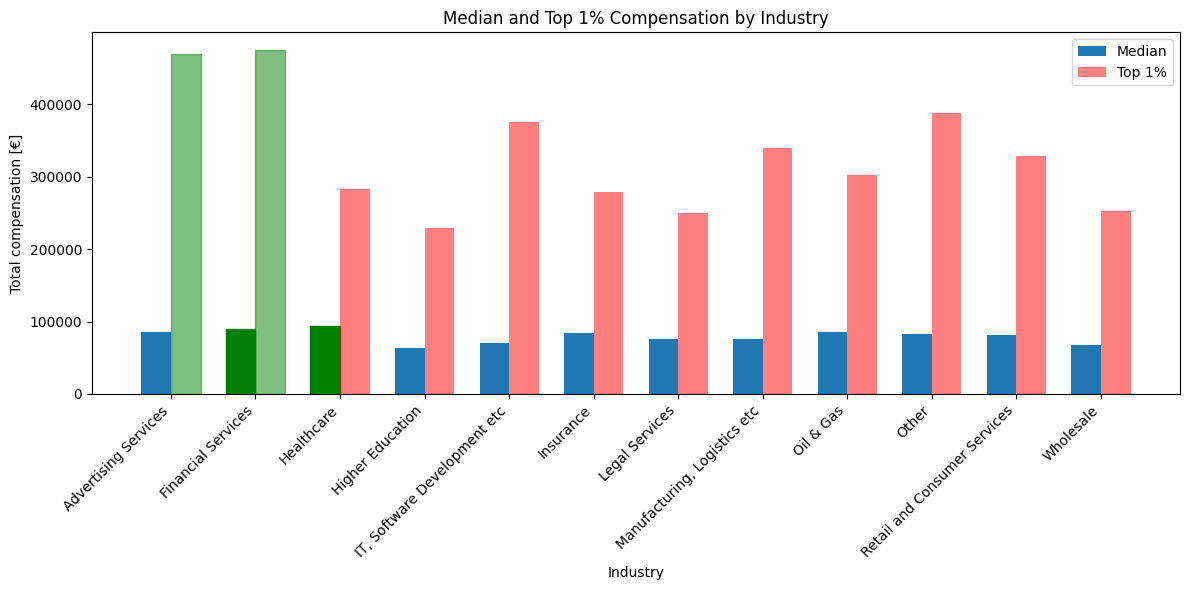

In [11]:
# Group by 'Industry' and calculate the maximum 'Converted_Salary'
max_comp_totals = converted_currency.groupby('Industry')['Converted_Salary'].quantile(0.99).reset_index()

# Group by 'Industry' and calculate the median 'Converted_Salary'
median_comp_totals = converted_currency.groupby('Industry')['Converted_Salary'].median().reset_index()

# Create a mapping of abbreviations for long industry names
abbreviations = {
    'Information Services, IT, Software Development, or other Technology': 'IT, Software Development etc',
    'Manufacturing, Transportation, or Supply Chain': 'Manufacturing, Logistics etc'
}

# Replace long industry names with abbreviations
max_comp_totals['Industry'] = max_comp_totals['Industry'].replace(abbreviations)
median_comp_totals['Industry'] = median_comp_totals['Industry'].replace(abbreviations)

# Set the figure size and create subplots
plt.figure(figsize=(12, 6))

# Calculate the number of industries
num_industries = len(max_comp_totals['Industry'])

# Define the width of each bar
bar_width = 0.35

# Define the x-axis positions for the bars
index = np.arange(num_industries)

# Create the grouped bar plots for median and top 1% values
plt.bar(index, median_comp_totals['Converted_Salary'], bar_width, label='Median')
plt.bar(index + bar_width, max_comp_totals['Converted_Salary'], bar_width, color='red', alpha=0.5, label='Top 1%')

# Set the x-axis labels, ticks, and rotation
plt.xlabel('Industry')
plt.ylabel('Total compensation [€]')
plt.title('Median and Top 1% Compensation by Industry')
plt.xticks(index + bar_width / 2, max_comp_totals['Industry'], rotation=45, ha='right')

# Add a legend
plt.legend()

# Define a threshold for the top 10%
threshold_max = max_comp_totals['Converted_Salary'].quantile(0.90)
threshold_median = median_comp_totals['Converted_Salary'].quantile(0.90)

# Apply conditional coloring to bars based on the threshold for both datasets
for i in range(num_industries):
    if max_comp_totals['Converted_Salary'][i] >= threshold_max:
        plt.gca().get_children()[i + num_industries].set_color('green')  # Set color for top 1% bars
    if median_comp_totals['Converted_Salary'][i] >= threshold_median:
        plt.gca().get_children()[i].set_color('green')  # Set color for median bars

# Show the plot
plt.tight_layout()
plt.show()


In 2023 the most profitable industry field as a developer was Financial Services with the median and peak compensation being the highest among the listed fields.  
Closely followed Advertising Services with a comparably high top end compensation of 470k.  
Median compensation showed less drastic differences, with Financial Services and Healthcare being in the top 10% of industry field.  

### It looks like the sector most closely connected to financial flows, also reaps the most fiscal gains in 2023.

### DevType

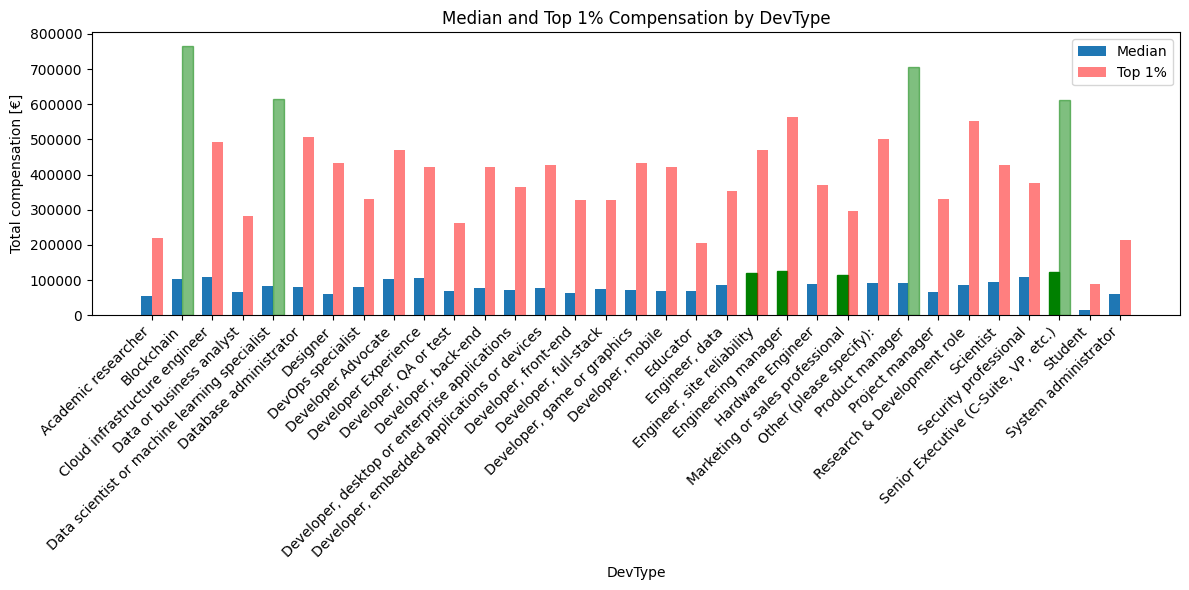

In [12]:
# Group by 'DevType' and calculate the maximum 'Converted_Salary'
max_comp_totals = converted_currency.groupby('DevType')['Converted_Salary'].quantile(0.99).reset_index()

# Group by 'Industry' and calculate the median 'Converted_Salary'
median_comp_totals = converted_currency.groupby('DevType')['Converted_Salary'].median().reset_index()

# Create a mapping of abbreviations for long industry names
abbreviations = {
    'Information Services, IT, Software Development, or other Technology': 'IT, Software Development etc',
    'Manufacturing, Transportation, or Supply Chain': 'Manufacturing, Logistics etc'
}

# Replace long industry names with abbreviations
max_comp_totals['DevType'] = max_comp_totals['DevType'].replace(abbreviations)
median_comp_totals['DevType'] = median_comp_totals['DevType'].replace(abbreviations)

# Set the figure size and create subplots
plt.figure(figsize=(12, 6))

# Calculate the number of industries
num_industries = len(max_comp_totals['DevType'])

# Define the width of each bar
bar_width = 0.35

# Define the x-axis positions for the bars
index = np.arange(num_industries)

# Create the grouped bar plots for median and top 1% values
plt.bar(index, median_comp_totals['Converted_Salary'], bar_width, label='Median')
plt.bar(index + bar_width, max_comp_totals['Converted_Salary'], bar_width, color='red', alpha=0.5, label='Top 1%')

# Set the x-axis labels, ticks, and rotation
plt.xlabel('DevType')
plt.ylabel('Total compensation [€]')
plt.title('Median and Top 1% Compensation by DevType')
plt.xticks(index + bar_width / 2, max_comp_totals['DevType'], rotation=45, ha='right')

# Add a legend
plt.legend()

# Define a threshold for the top 10%
threshold_max = max_comp_totals['Converted_Salary'].quantile(0.90)
threshold_median = median_comp_totals['Converted_Salary'].quantile(0.90)

# Apply conditional coloring to bars based on the threshold for both datasets
for i in range(num_industries):
    if max_comp_totals['Converted_Salary'][i] >= threshold_max:
        plt.gca().get_children()[i + num_industries].set_color('green')  # Set color for top 1% bars
    if median_comp_totals['Converted_Salary'][i] >= threshold_median:
        plt.gca().get_children()[i].set_color('green')  # Set color for median bars

# Show the plot
plt.tight_layout()
plt.show()



<img src="images/green-divider.png" style="width: 100%;" />


### How much does remote working matter to employees?

### Whats the distribution of remote work and education level?

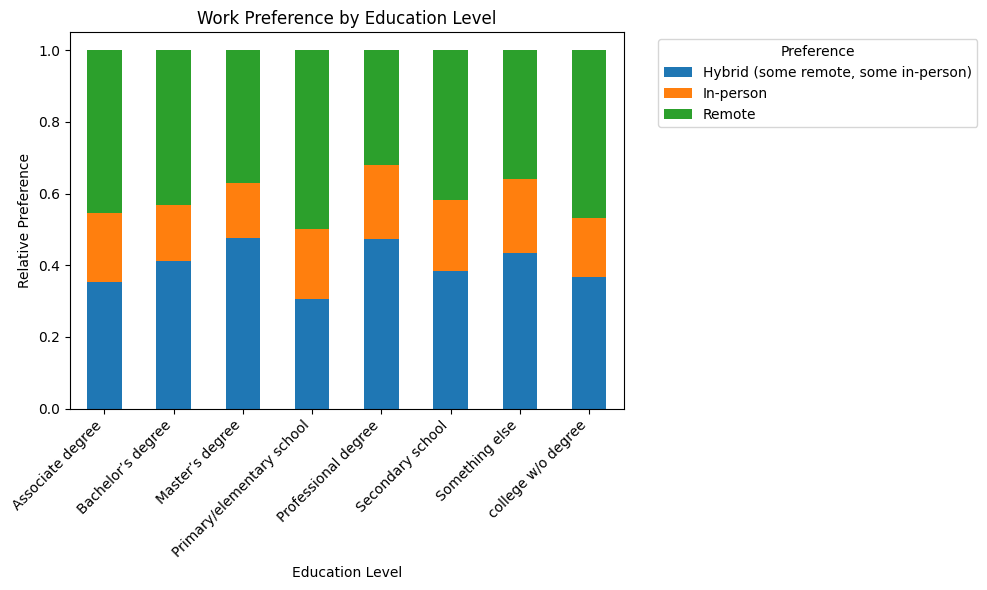

In [14]:
# Define a custom function to calculate relative preferences within each group
def calculate_relative_preferences(group):
    total = group['EdLevel'].count()  # Total count of preferences in the group
    relative_preferences = group['RemoteWork'].value_counts() / total  # Calculate relative preferences
    return relative_preferences

# Create a mapping of abbreviations for long EdLevel names
abbreviations = {
    'Associate degree (A.A., A.S., etc.)': 'Associate degree',
    "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "Bachelor’s degree",
    "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "Master’s degree",
    "Primary/elementary school": "Primary/elementary school",
    "Professional degree (JD, MD, Ph.D, Ed.D, etc.)": "Professional degree",
    "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "Secondary school",
    "Some college/university study without earning a degree": "college w/o degree",
    "Something else": "Something else"
}

# Map the 'EdLevel' column to the abbreviated names
df['Abbreviated_EdLevel'] = df['EdLevel'].map(abbreviations)

# Group the data by 'EdLevel' and apply the custom function to calculate relative preferences
grouped_data = df.groupby('Abbreviated_EdLevel').apply(calculate_relative_preferences).unstack(fill_value=0)

# Normalize each row so that the total height is 1.0
normalized_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)

# Create a stacked bar chart
ax = normalized_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Education Level')
plt.ylabel('Relative Preference')
plt.title('Work Preference by Education Level')
plt.xticks(rotation=45, ha='right')

# Place the legend outside the bar area
ax.legend(title='Preference', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


The survey allows for multiple entries in the Employment field. For better visualization I count the individual categories listed and create plots how the relate to work preferences.

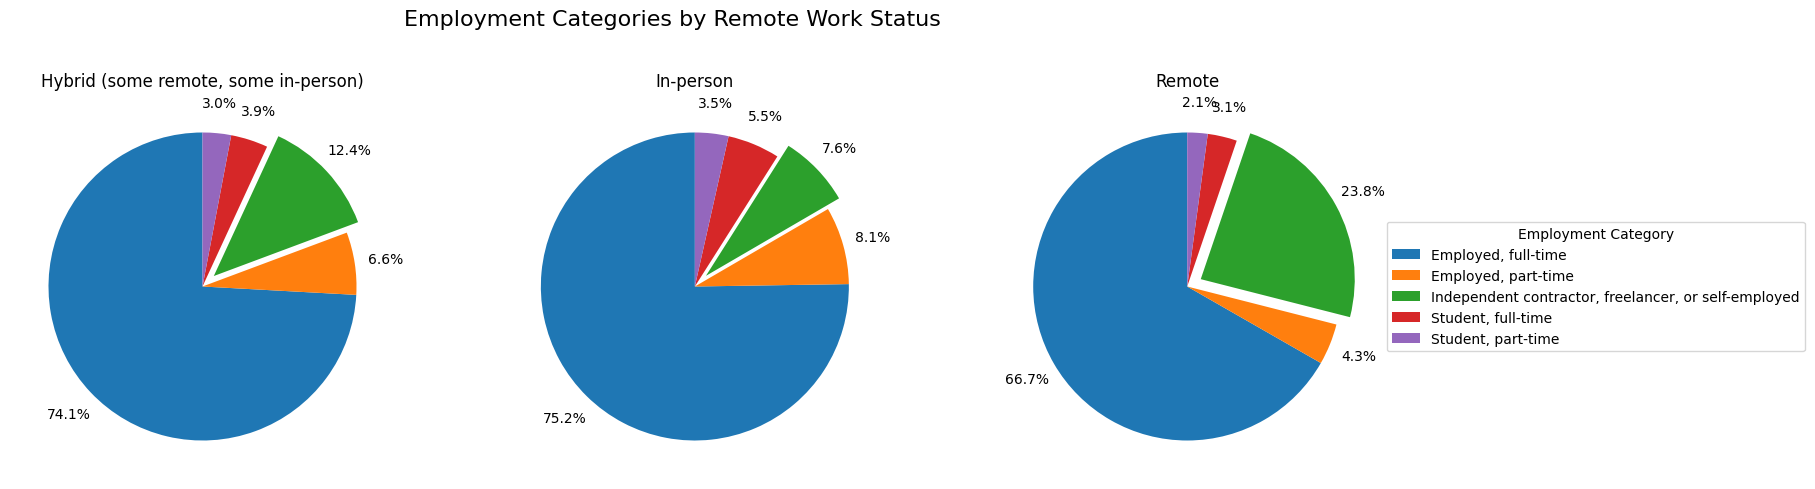

In [15]:
# Create binary columns for each category
categories = ['Employed, full-time', 
              'Employed, part-time', 
              'Independent contractor, freelancer, or self-employed',
              'Student, full-time',
              'Student, part-time']

for category in categories:
    df[category] = df['Employment'].str.contains(category, case=False, na=False).astype(int)

# Group by 'RemoteWork' and sum the counts for each category
grouped_data = df.groupby('RemoteWork')[categories].sum().reset_index()

# Plot the data as pie charts
fig, axes = plt.subplots(nrows=1, ncols=len(grouped_data), figsize=(18, 5), subplot_kw=dict(aspect="equal"))

explode = (0, 0, 0.1, 0, 0)


# Iterate through each 'RemoteWork' category and create a pie chart
for i, (remote_work_status, data) in enumerate(grouped_data.groupby('RemoteWork')):
    ax = axes[i]
    labels = data[categories].columns
    sizes = data[categories].iloc[0]
    wedges, texts, autotexts = ax.pie(
        sizes, autopct='%1.1f%%', startangle=90,
        pctdistance=1.2, textprops=dict(color="black"),
        explode=explode
    )

    # Set title
    ax.set_title(remote_work_status)

# Create legend
ax.legend(wedges, labels, title="Employment Category", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.suptitle('Employment Categories by Remote Work Status', y=1.05, fontsize=16)
plt.show()


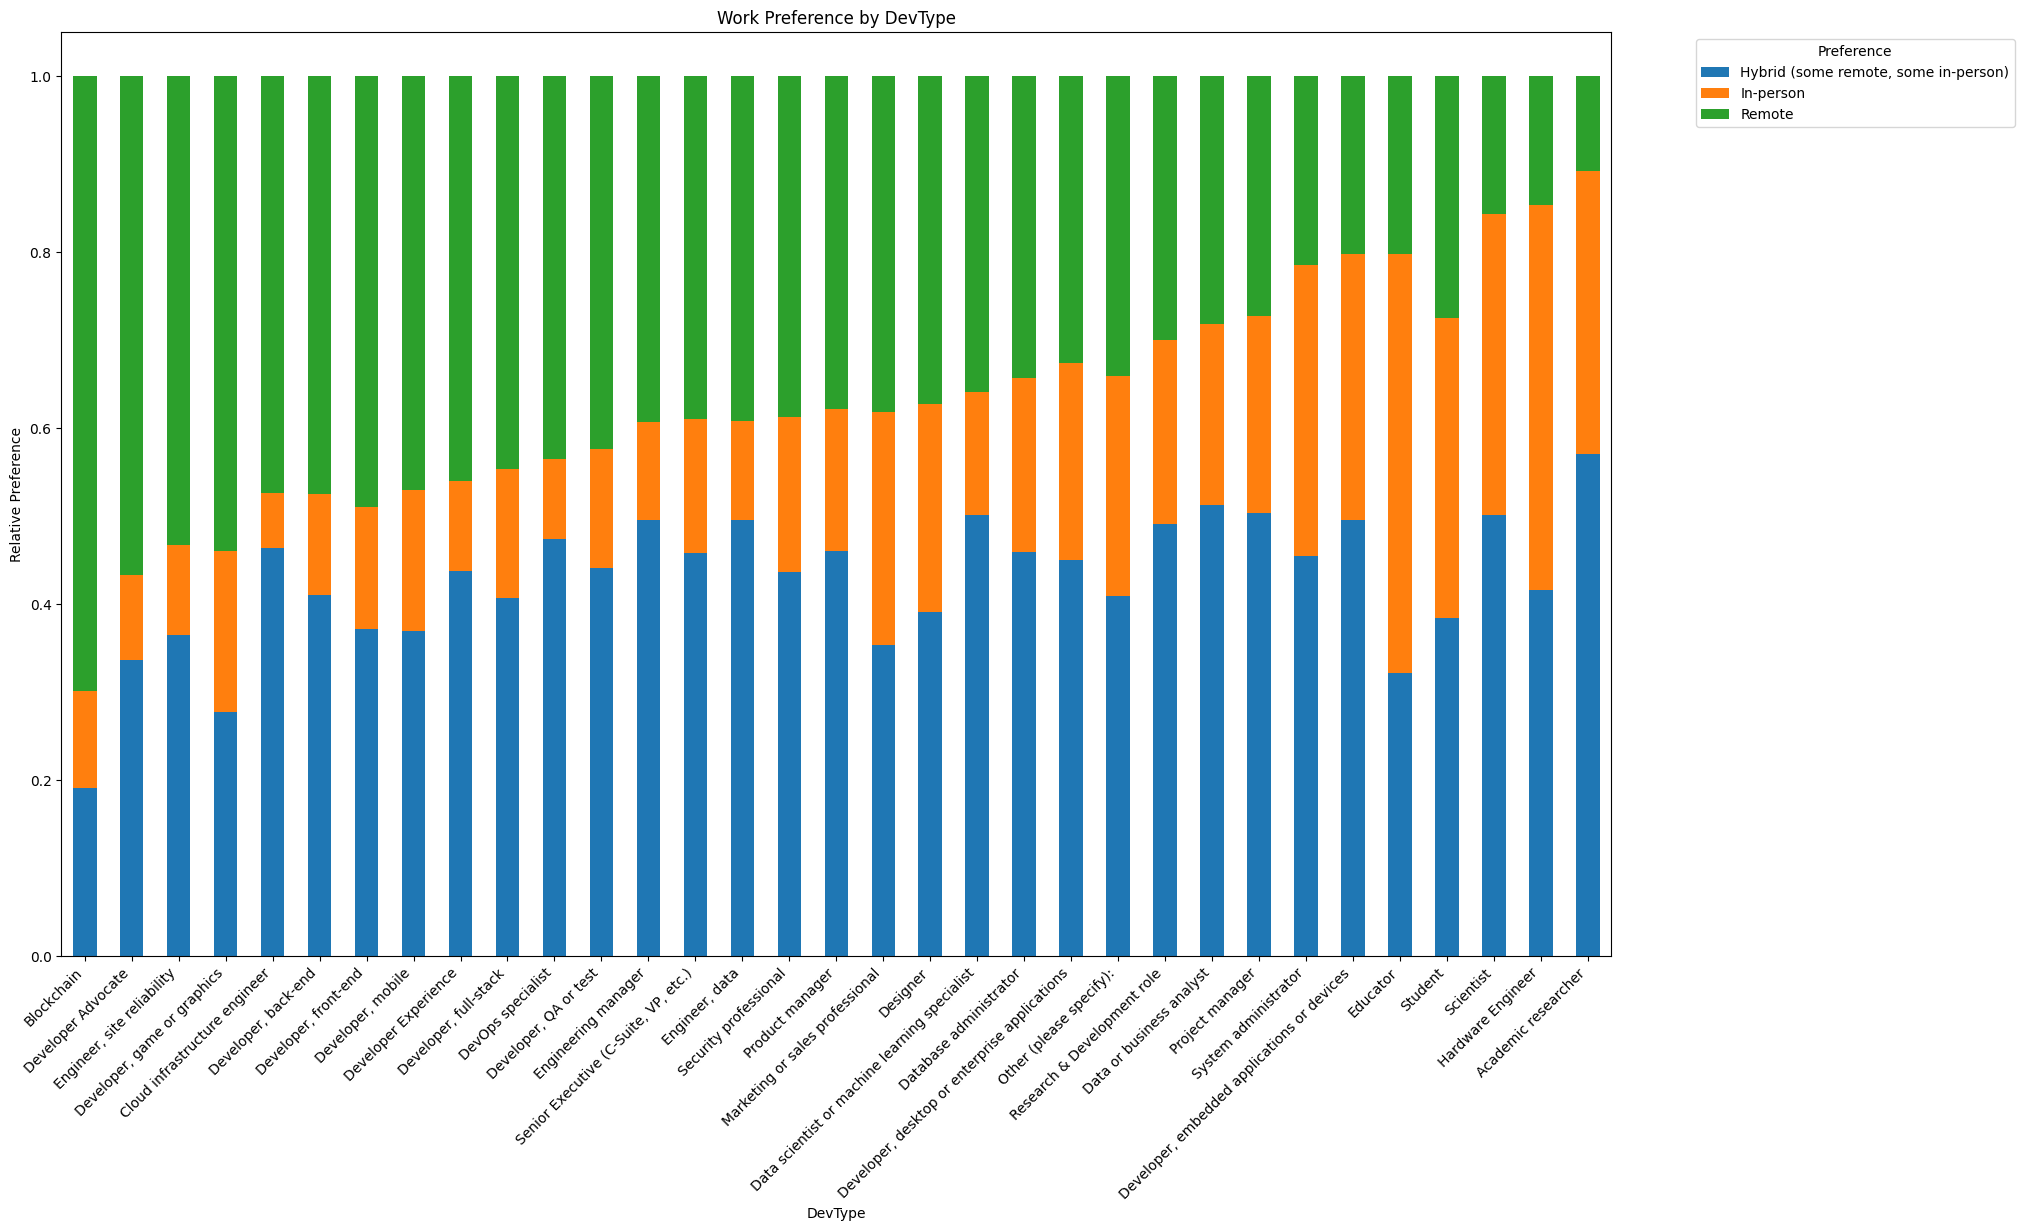

In [19]:
# Define a custom function to calculate relative preferences within each group
def calculate_relative_preferences(group):
    total = group['DevType'].count()  # Total count of preferences in the group
    relative_preferences = group['RemoteWork'].value_counts() / total  # Calculate relative preferences
    return relative_preferences

# Group the data by 'DevType' and apply the custom function to calculate relative preferences
grouped_data = df.groupby('DevType').apply(calculate_relative_preferences).unstack(fill_value=0)

# Calculate the percentage of people choosing 'Remote'
percentage_remote = grouped_data['Remote'].mul(100)

# Sort the dataframe based on the percentage of people choosing 'Remote'
sorted_index = percentage_remote.sort_values(ascending=False).index
grouped_data_sorted = grouped_data.reindex(sorted_index)

# Normalize each row so that the total height is 1.0
normalized_data = grouped_data_sorted.div(grouped_data_sorted.sum(axis=1), axis=0)

# Create a stacked bar chart
ax = normalized_data.plot(kind='bar', stacked=True, figsize=(20, 12))
plt.xlabel('DevType')
plt.ylabel('Relative Preference')
plt.title('Work Preference by DevType')
plt.xticks(rotation=45, ha='right')

# Place the legend outside the bar area
ax.legend(title='Preference', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

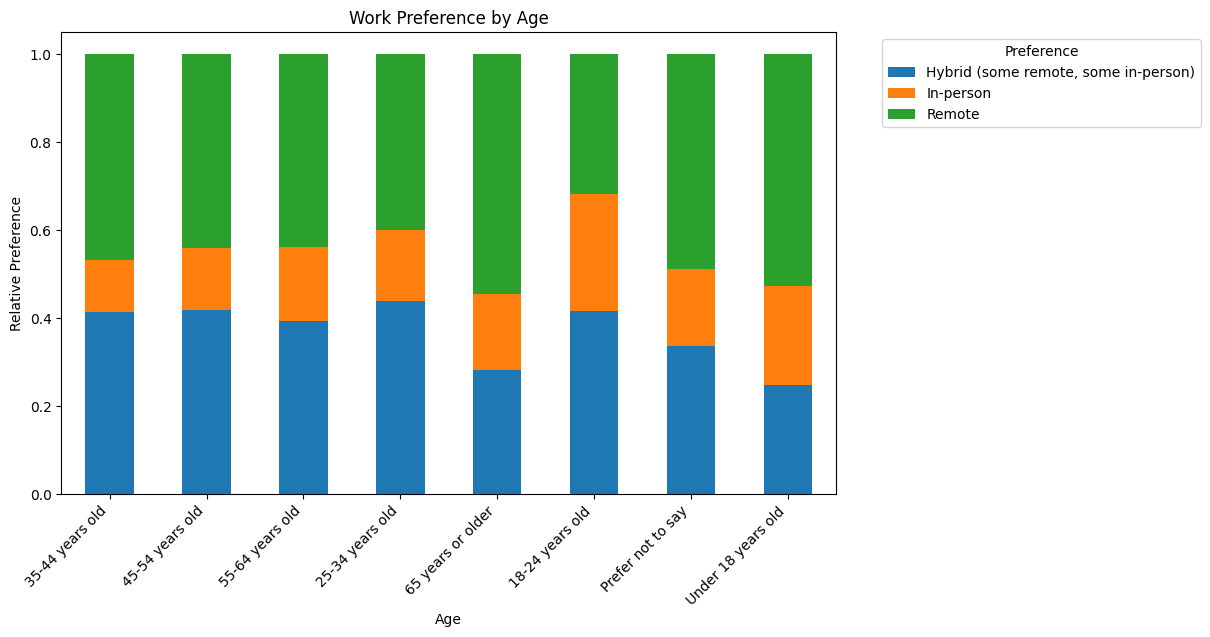

In [27]:
# Define a custom function to calculate relative preferences within each group
def calculate_relative_preferences(group):
    total = group['Age'].count()  # Total count of preferences in the group
    relative_preferences = group['RemoteWork'].value_counts() / total  # Calculate relative preferences
    return relative_preferences

# Group the data by 'Age' and apply the custom function to calculate relative preferences
grouped_data = df.groupby('Age').apply(calculate_relative_preferences).unstack(fill_value=0)

# Calculate the percentage of people choosing 'Remote'
percentage_remote = grouped_data['Remote'].mul(100)

# Sort the dataframe based on the percentage of people choosing 'Remote'
sorted_index = percentage_remote.sort_values(ascending=False).index
grouped_data_sorted = grouped_data.reindex(sorted_index)

# Normalize each row so that the total height is 1.0
normalized_data = grouped_data_sorted.div(grouped_data_sorted.sum(axis=1), axis=0)

# Create a stacked bar chart
ax = normalized_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Age')
plt.ylabel('Relative Preference')
plt.title('Work Preference by Age')
plt.xticks(rotation=45, ha='right')

# Place the legend outside the bar area
ax.legend(title='Preference', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

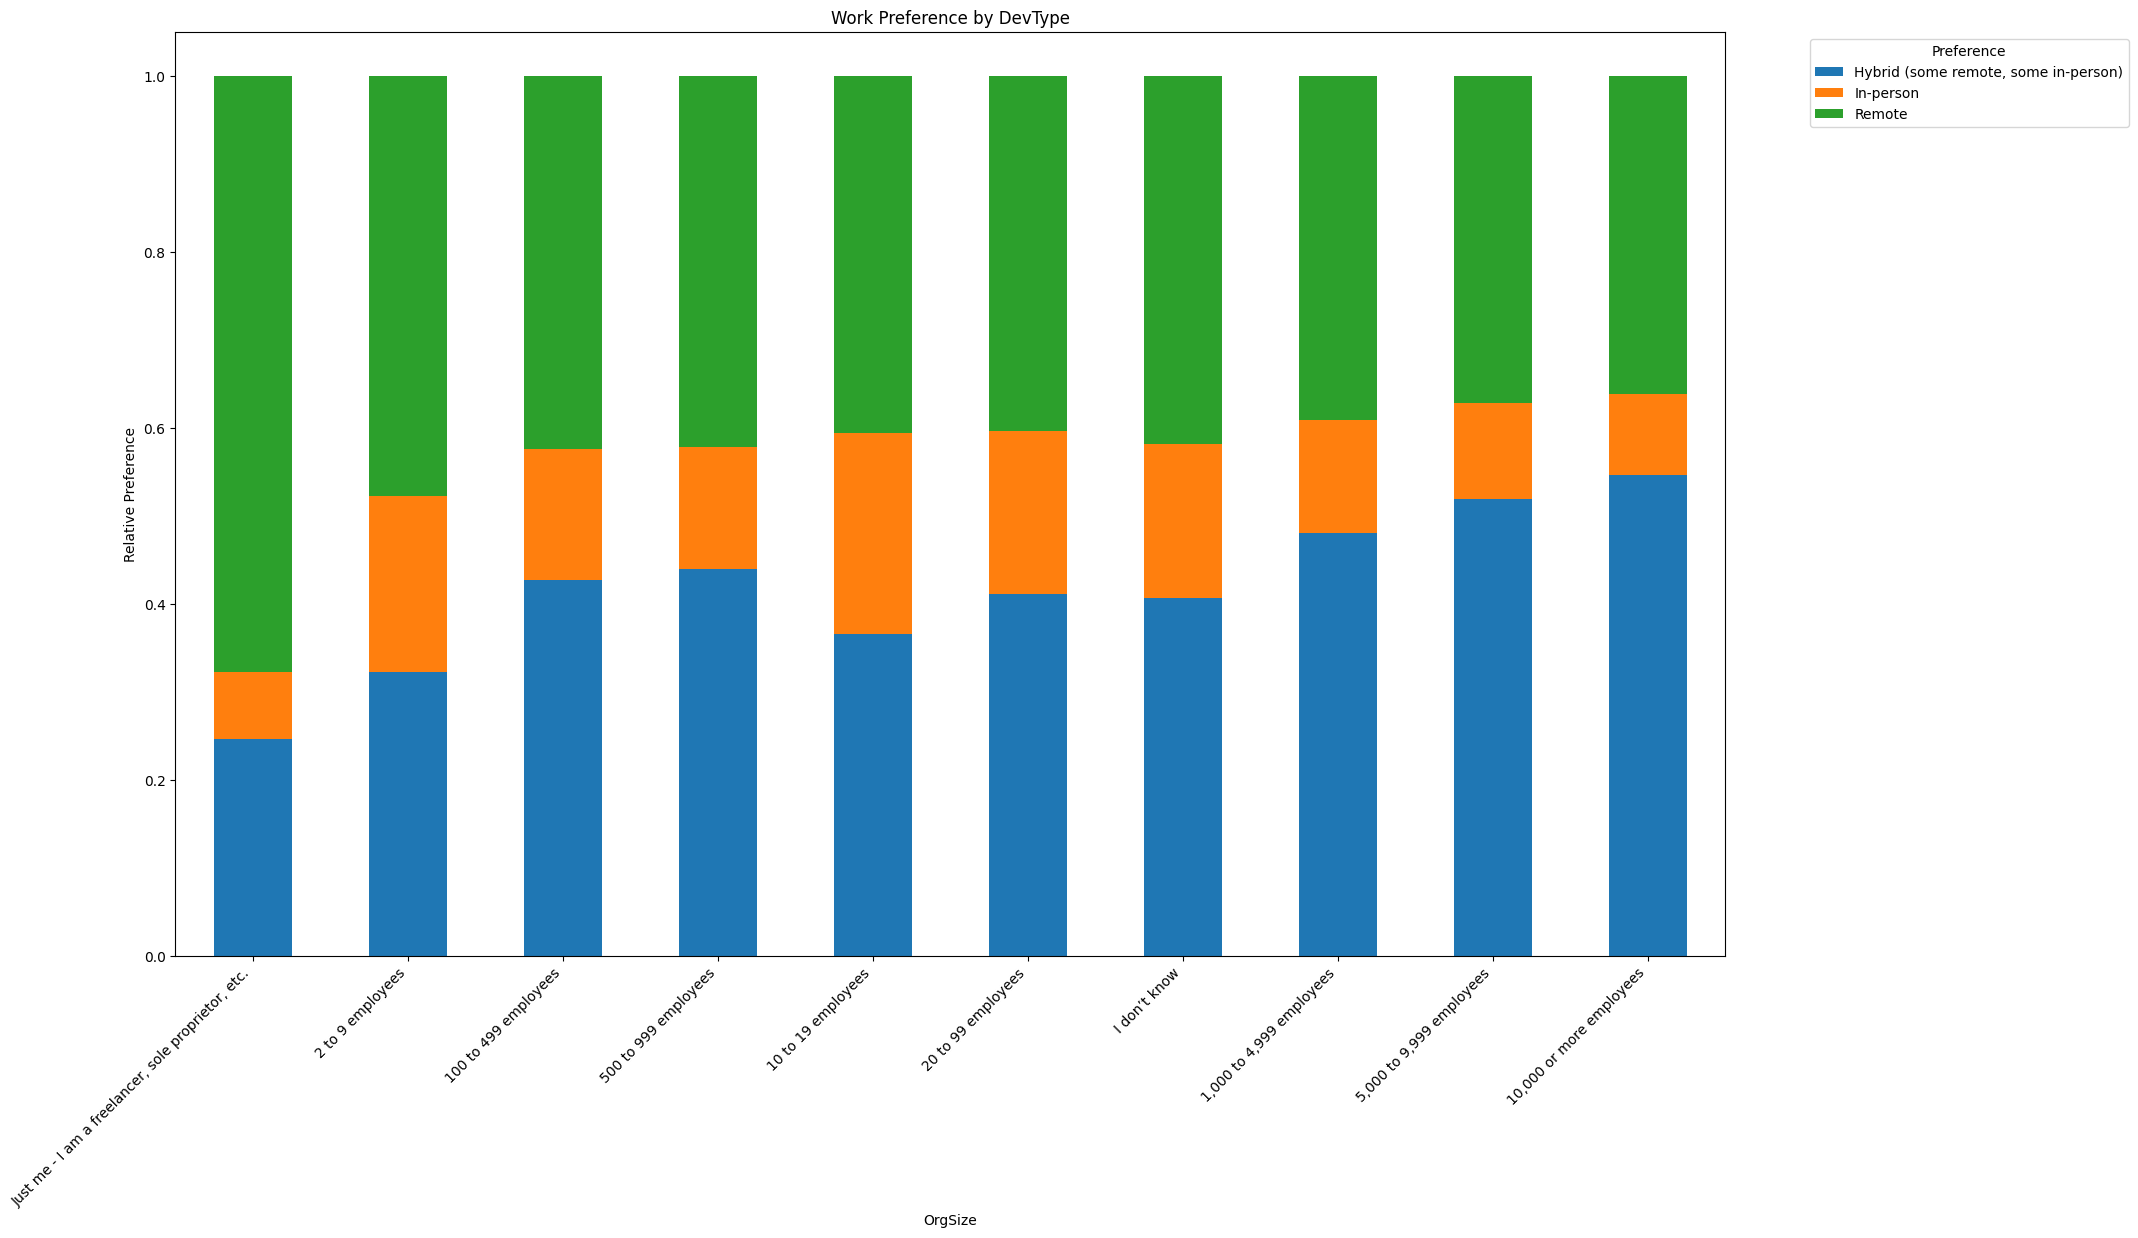

In [24]:
# Define a custom function to calculate relative preferences within each group
def calculate_relative_preferences(group):
    total = group['OrgSize'].count()  # Total count of preferences in the group
    relative_preferences = group['RemoteWork'].value_counts() / total  # Calculate relative preferences
    return relative_preferences

# Group the data by 'DevType' and apply the custom function to calculate relative preferences
grouped_data = df.groupby('OrgSize').apply(calculate_relative_preferences).unstack(fill_value=0)

# Calculate the percentage of people choosing 'Remote'
percentage_remote = grouped_data['Remote'].mul(100)

# Sort the dataframe based on the percentage of people choosing 'Remote'
sorted_index = percentage_remote.sort_values(ascending=False).index
grouped_data_sorted = grouped_data.reindex(sorted_index)

# Normalize each row so that the total height is 1.0
normalized_data = grouped_data_sorted.div(grouped_data_sorted.sum(axis=1), axis=0)

# Create a stacked bar chart
ax = normalized_data.plot(kind='bar', stacked=True, figsize=(20, 12))
plt.xlabel('OrgSize')
plt.ylabel('Relative Preference')
plt.title('Work Preference by OrgSize')
plt.xticks(rotation=45, ha='right')

# Place the legend outside the bar area
ax.legend(title='Preference', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


<img src="images/green-divider.png" style="width: 100%;" />


### How does coding experience affect the level of pay?

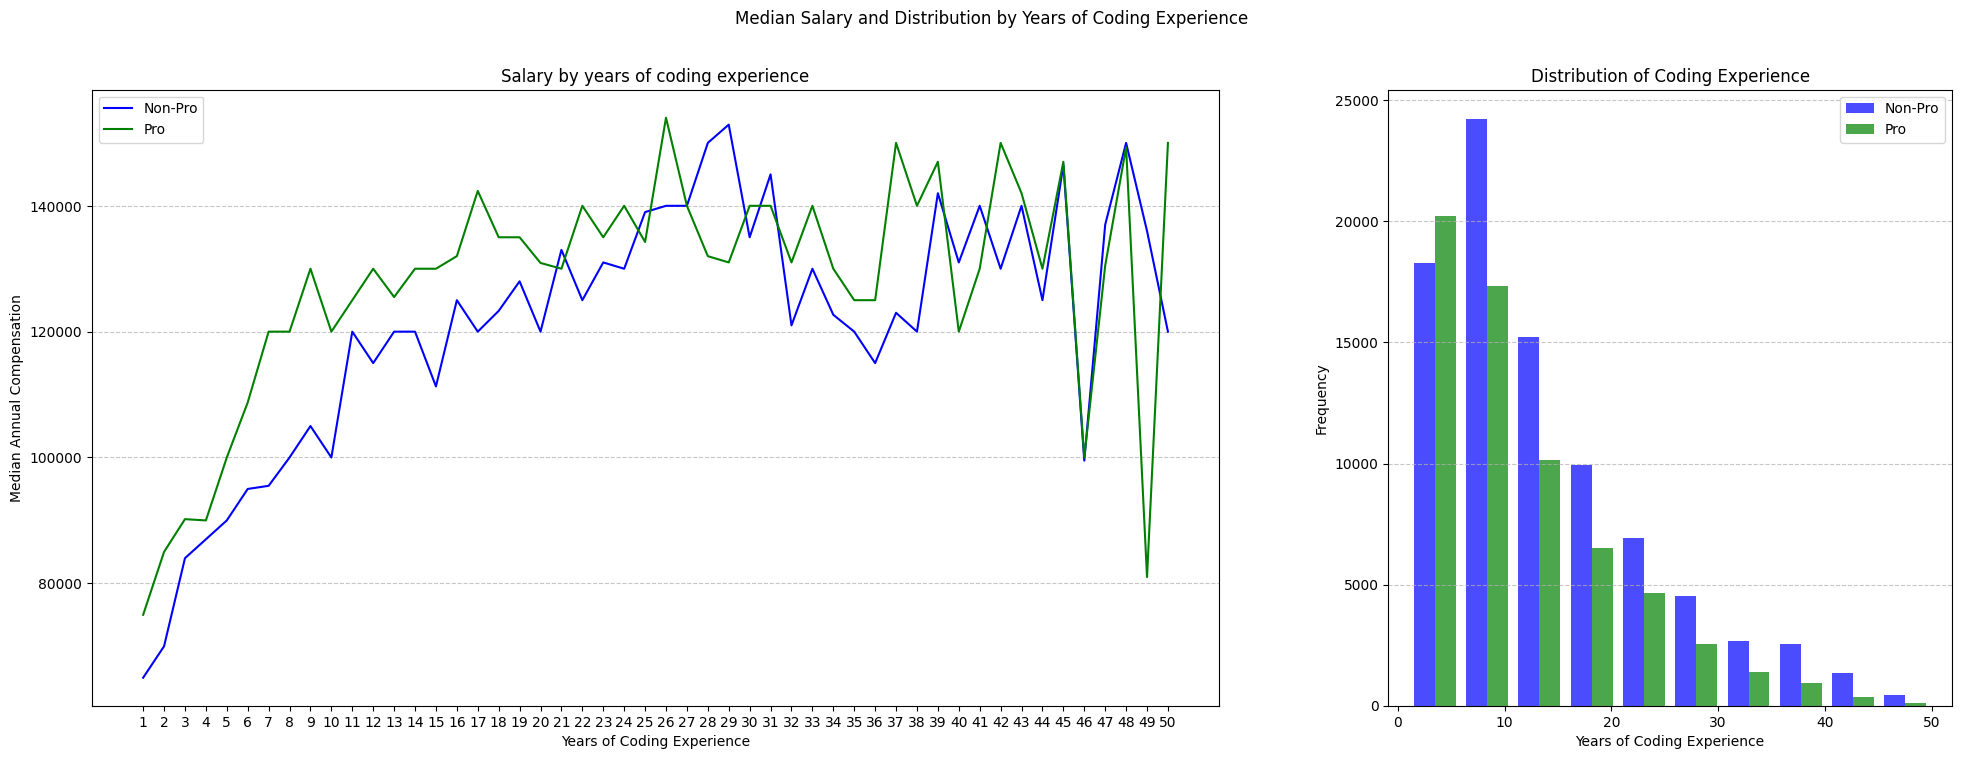

In [76]:
# Convert "YearsCode" and "YearsCodePro" to numeric values
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce')
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')

# Group by "YearsCode" and calculate median compensation
median_compensation = df.groupby('YearsCode')['CompTotal'].median().reset_index()

# Group by "YearsCodePro" and calculate median compensation
median_compensation_pro = df.groupby('YearsCodePro')['CompTotal'].median().reset_index()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), gridspec_kw={'width_ratios': [2, 1]})

# Plot the first line on the first subplot
ax1.plot(median_compensation['YearsCode'], median_compensation['CompTotal'], color='blue', label='Non-Pro')
ax1.plot(median_compensation_pro['YearsCodePro'], median_compensation_pro['CompTotal'], color='green', label='Pro')
ax1.set_title('Salary by years of coding experience')
ax1.set_xlabel('Years of Coding Experience')
ax1.set_ylabel('Median Annual Compensation')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xticks(median_compensation['YearsCode'])
ax1.legend(loc='upper left')


# Plot histograms on the second subplot
ax2.hist([df['YearsCode'], df['YearsCodePro']], bins=10, color=['blue', 'green'], alpha=0.7, label=['Non-Pro', 'Pro'])
ax2.set_title('Distribution of Coding Experience')
ax2.set_xlabel('Years of Coding Experience')
ax2.set_ylabel('Frequency')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()

# Add a common title for both subplots
plt.suptitle('Median Salary and Distribution by Years of Coding Experience')

plt.show()



<img src="images/green-divider.png" style="width: 100%;" />
